# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [2]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


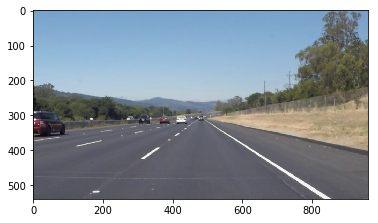

In [3]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images  
`cv2.cvtColor()` to grayscale or change color  
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [132]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    # return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

# -------------- MY CODE -------------------#
# Convert an image from RGB to HSV
def to_hsv(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

# Takes as input an image, a lower HSV threshold and a higher HSV threshold
# and return a mask used to filter out all the colors that are not in range
def mask_color(hsv, low, high):
    mask = cv2.inRange(hsv, low, high)
    return mask

# Utility function to check if a value is not +/-inf
def check_inf(value):
    return abs(value) < math.inf

# Utility function used to filter out all the slopes that are not in the
# range [MIN_SLOPE, MAX_SLOPE]
def slope_in_range(slope):
    MIN_SLOPE = 0.3
    MAX_SLOPE = 1.0
    return MIN_SLOPE <= abs(slope) <= MAX_SLOPE

def draw_lines(img, lines, color=[255, 0, 0], thickness=12):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    
    
    First, I tried to follow https://knowledge.udacity.com/questions/18578
    but the result obtained wasn't satisying. So, I decided to take the slope
    and coefficient of the line and average them instead of the "lower_x_values" as suggested
    in point 4 of https://knowledge.udacity.com/questions/18578.
    
    I also filtered the slope in order to have them in a range so as to avoid strange behaviours.
    Following point 1 of https://knowledge.udacity.com/questions/18578, I used the sign of the slope
    to divide them in left_line_slopes and right_line_slopes.
    
    Then, I proceeded with averaging slopes and coefficient and use the means  to find
    a lower_x and an upper_x. In order to find the x, I used two y points:
        - the y max dimension of the image
        - the minimum y point found in all the lines that are in slope_range
        
    Finally, I use all these information to draw the lines
        
    Some maths:
    if we have a line defined as y = slope*x + coeff, we have that:
        - slope = ((y2-y1)/(x2-x1))
        - coeff = y1 - slope*x1 (could also be y2 and x2)
        
    """
    # In order to find the minimum, start with the max value and
    # update it accordingly
    min_y = img.shape[0]
    max_y = img.shape[0]
    
    left_line_slopes = []
    left_line_coeff = []
    right_line_slopes = []
    right_line_coeff = []
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            slope = ((y2-y1)/(x2-x1))
            coeff = y1 - slope*x1
            
            if slope_in_range(slope) and check_inf(slope):
                if slope > 0:
                    # Right line case (y axis is inverted in the image)
                    right_line_slopes.append(slope)
                    right_line_coeff.append(coeff)
                elif slope < 0:
                    # Left line case (y axis is inverted in the image)
                    left_line_slopes.append(slope)
                    left_line_coeff.append(coeff)
                
                min_y = min(y1, y2, min_y)
    
    # if len(right_line_slopes) > 0 I also have a coeff, so 
    # it's no use to check len(right_line_coeff)
    if len(right_line_slopes) > 0:
        right_line_slope_mean = np.mean(right_line_slopes, dtype=np.float64)
        right_line_coeff_mean = np.mean(right_line_coeff, dtype=np.float64)
        
        # due to precision, np.mean can return inf or -inf: check if values are correct before using them
        if check_inf(right_line_slope_mean) and check_inf(right_line_coeff_mean):
            max_x = int((max_y - right_line_coeff_mean)/right_line_slope_mean)
            min_x = int((min_y - right_line_coeff_mean)/right_line_slope_mean)
            cv2.line(img, (min_x, min_y), (max_x, max_y), color, thickness) 
    
    # if len(left_line_slopes) > 0 I also have a coeff, so 
    # it's no use to check len(left_line_coeff)
    if len(left_line_slopes) > 0:
        left_line_slope_mean = np.mean(left_line_slopes, dtype=np.float64)
        left_line_coeff_mean = np.mean(left_line_coeff, dtype=np.float64)
        
        # due to precision, np.mean can return inf or -inf: check if values are correct before using them
        if check_inf(left_line_slope_mean) and check_inf(left_line_coeff_mean):
            max_x = int((max_y - left_line_coeff_mean)/left_line_slope_mean)
            min_x = int((min_y - left_line_coeff_mean)/left_line_slope_mean)
            cv2.line(img, (min_x, min_y), (max_x, max_y), color, thickness) 
        
# ------------- END OF MY CODE -------------#

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [6]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [ ]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.

# Define Gaussian Filter parameters
GAUSSIAN_KERNEL_SIZE = 3
# End Gaussian Filter parameters

# Define Canny parameters
CANNY_LOW_THRESHOLD = 75
CANNY_HIGH_THRESHOLD = 150
# End Canny parameters

# Do not use with challenge (image's size is different)
# Define polygon
# imshape = image.shape
# LEFT_BOTTOM = (100, imshape[0])
# RIGHT_BOTTOM = (930, imshape[0])
# Y_HORIZON = 320
# LEFT_UP = (400, Y_HORIZON)
# RIGHT_UP = (590, Y_HORIZON)
# VERTICES = np.array([[LEFT_BOTTOM , LEFT_UP, RIGHT_UP, RIGHT_BOTTOM]], dtype=np.int32)

# Challenge images have different size, so I have to find a polygon using percentage
# For percentage I'm using the polygon found before
LEFT_BOTTOM_PERC = 100.0/960.0
RIGHT_BOTTOM_PERC = 930.0/960.0
Y_HORIZON_PERC = 320.0/540.0
LEFT_UP_PERC = 400.0/960.0
RIGHT_UP_PERC = 590.0/960.0

def get_vertices(img):
    left_bottom = (img.shape[1] * LEFT_BOTTOM_PERC, img.shape[0])
    right_bottom = (img.shape[1] * RIGHT_BOTTOM_PERC, img.shape[0])
    left_up = (img.shape[1] * LEFT_UP_PERC, img.shape[0] * Y_HORIZON_PERC)
    right_up = (img.shape[1] * RIGHT_UP_PERC, img.shape[0] * Y_HORIZON_PERC)
    vertices = np.array([[left_bottom , left_up, right_up, right_bottom]], dtype=np.int32)
    return vertices

# End polygon

# Define Hough transform parameters
RHO = 3.5 # distance resolution in pixels of the Hough grid
THETA = np.pi/180 # angular resolution in radians of the Hough grid
HOUGH_THRESHOLD = 30    # minimum number of votes (intersections in Hough grid cell)
HOUGH_MIN_LINE_LENGTH = 5 #minimum number of pixels making up a line
HOUGH_MAX_LINE_GAP = 25    # maximum gap in pixels between connectable line segments
# End Hough transform parameters

# In order to improve the quality of filtering, I switched from grayscale to hsv, which is more robust 
# in situations where illumination changes. Aside from converting to hsv and filtering by colors, 
# the pipeline resemble the one seen in the course material.
def my_pipeline(image):
    hsv = to_hsv(image) # Convert the image to HSV
    blur_gray = gaussian_blur(hsv, GAUSSIAN_KERNEL_SIZE)
    
    # Define color ranges and apply color mask, so as to filter per color
    yellow_hsv_low  = np.array([ 0, 100, 100])
    yellow_hsv_high = np.array([ 50, 255, 255])

    white_hsv_low  = np.array([  20,   0,   180])
    white_hsv_high = np.array([ 255,  80, 255])
    
    mask_yellow = mask_color(blur_gray, yellow_hsv_low, yellow_hsv_high)
    mask_white = mask_color(blur_gray, white_hsv_low, white_hsv_high)
    color_masked_img = cv2.bitwise_or(mask_yellow, mask_white) 
    
    edges = canny(color_masked_img, CANNY_LOW_THRESHOLD, CANNY_HIGH_THRESHOLD)
    vertices = get_vertices(image)
    masked_edges = region_of_interest(edges, vertices)
    line_image = hough_lines(masked_edges, RHO, THETA, HOUGH_THRESHOLD, HOUGH_MIN_LINE_LENGTH, HOUGH_MAX_LINE_GAP)
    lines_edges = weighted_img(image, line_image)
    
    return lines_edges

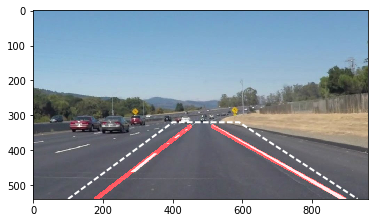

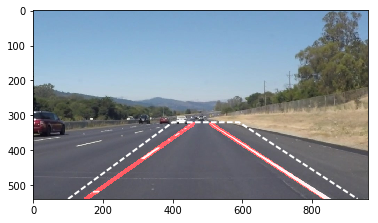

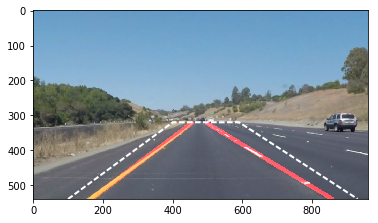

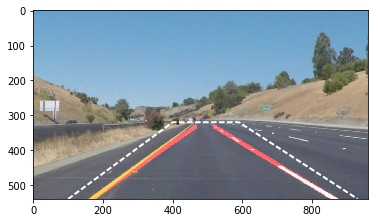

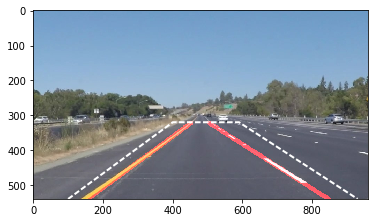

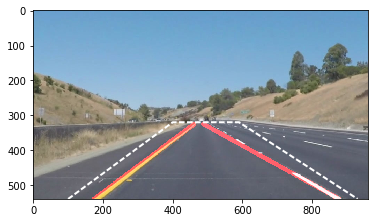

In [136]:
# Try the pipeline with the test_images provided
for file in os.listdir("test_images/"):
    image = mpimg.imread("test_images/" + file)
    lines_edges = my_pipeline(image)
    vertices = get_vertices(image)
    x = [vertices[0][0][0], vertices[0][1][0], vertices[0][2][0], vertices[0][3][0]]
    y = [vertices[0][0][1], vertices[0][1][1], vertices[0][2][1], vertices[0][3][1]]
    plt.plot(x, y, 'w--', lw=2)
    plt.imshow(lines_edges)
    plt.show()
    cv2.imwrite("test_images_output/" + file, lines_edges)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [12]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Imageio: 'ffmpeg.linux64' was not found on your computer; downloading it now.
Try 1. Download from https://github.com/imageio/imageio-binaries/raw/master/ffmpeg/ffmpeg.linux64 (27.2 MB)
Downloading: 8192/28549024 bytes (0.0188416/28549024 bytes (0.7901120/28549024 bytes (3.21400832/28549024 bytes (4.9%1753088/28549024 bytes (6.1%2146304/28549024 bytes (7.5%2539520/28549024 bytes (8.9%2932736/28549024 bytes (10.33325952/28549024 bytes (11.63702784/28549024 bytes (13.04096000/28549024 bytes (14.34489216/28549024 bytes (15.74882432/28549024 bytes (17.15275648/28549024 bytes (18.55668864/28549024 bytes (19.96062080/28549024 bytes (21.26455296/28549024 bytes (22.66848512/28549024 bytes (24.07241728/28549024 bytes (25.47634944/28549024 bytes (26.78028160/28549024 bytes (28.18421376/28549024 bytes (29.58814592/28549024 bytes (30.99207808/28549024 bytes (32.39601024/28549024 bytes (33.69977856/28549024 bytes (34.910371072/28549024 bytes (36.3%10764288/28549024 bytes (37.7%11157504/28549024 byt

In [78]:
# Utility function used to find out that challenge video has different image's size
def print_image_param(image):
    print('This image is:', type(image), 'with dimensions:', image.shape)

def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # print_image_param(image)
    result = my_pipeline(image)
    # you should return the final output (image where lines are drawn on lanes)
    return result

Let's try the one with the solid white lane on the right first ...

In [137]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4









  0%|          | 0/222 [00:00<?, ?it/s]






  3%|▎         | 7/222 [00:00<00:03, 64.96it/s]






  6%|▋         | 14/222 [00:00<00:03, 65.02it/s]






  9%|▉         | 21/222 [00:00<00:03, 65.59it/s]






 13%|█▎        | 28/222 [00:00<00:02, 65.59it/s]






 16%|█▌        | 35/222 [00:00<00:02, 65.37it/s]






 19%|█▉        | 42/222 [00:00<00:02, 65.45it/s]






 22%|██▏       | 48/222 [00:00<00:03, 53.02it/s]






 24%|██▍       | 54/222 [00:01<00:04, 41.05it/s]






 27%|██▋       | 59/222 [00:01<00:04, 40.05it/s]






 29%|██▉       | 64/222 [00:01<00:04, 39.08it/s]






 31%|███       | 69/222 [00:01<00:03, 38.71it/s]






 33%|███▎      | 73/222 [00:01<00:03, 38.87it/s]






 35%|███▌      | 78/222 [00:01<00:03, 39.09it/s]






 37%|███▋      | 83/222 [00:01<00:03, 39.49it/s]






 39%|███▉      | 87/222 [00:01<00:03, 38.44it/s]






 41%|████▏     | 92/222 [00:02<00:03, 39.82it/s]






 44%|████▎     | 97/222 [00:02<00:03, 38.76it/s]






 45%|████▌   

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 2.97 s, sys: 282 ms, total: 3.25 s
Wall time: 6.34 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [19]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [138]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4









  0%|          | 0/682 [00:00<?, ?it/s]






  1%|          | 7/682 [00:00<00:10, 67.13it/s]






  2%|▏         | 14/682 [00:00<00:09, 67.40it/s]






  3%|▎         | 21/682 [00:00<00:09, 67.15it/s]






  4%|▍         | 28/682 [00:00<00:09, 67.14it/s]






  5%|▌         | 35/682 [00:00<00:09, 66.20it/s]






  6%|▌         | 42/682 [00:00<00:09, 66.37it/s]






  7%|▋         | 48/682 [00:00<00:11, 55.58it/s]






  8%|▊         | 54/682 [00:00<00:13, 48.02it/s]






  9%|▊         | 59/682 [00:01<00:14, 43.56it/s]






  9%|▉         | 64/682 [00:01<00:15, 41.16it/s]






 10%|█         | 69/682 [00:01<00:15, 38.86it/s]






 11%|█         | 73/682 [00:01<00:17, 35.56it/s]






 11%|█▏        | 77/682 [00:01<00:17, 35.41it/s]






 12%|█▏        | 81/682 [00:01<00:16, 35.84it/s]






 12%|█▏        | 85/682 [00:01<00:16, 35.13it/s]






 13%|█▎        | 89/682 [00:01<00:17, 33.41it/s]






 14%|█▎        | 93/682 [00:02<00:17, 33.78it/s]






 14%|█▍      

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 9.41 s, sys: 869 ms, total: 10.3 s
Wall time: 20.2 s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [139]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4









  0%|          | 0/251 [00:00<?, ?it/s]






  2%|▏         | 4/251 [00:00<00:06, 39.02it/s]






  4%|▎         | 9/251 [00:00<00:06, 39.99it/s]






  5%|▌         | 13/251 [00:00<00:06, 38.96it/s]






  7%|▋         | 17/251 [00:00<00:06, 38.90it/s]






  8%|▊         | 21/251 [00:00<00:05, 39.14it/s]






 10%|▉         | 25/251 [00:00<00:05, 38.60it/s]






 12%|█▏        | 29/251 [00:00<00:05, 38.94it/s]






 13%|█▎        | 33/251 [00:00<00:05, 39.11it/s]






 15%|█▍        | 37/251 [00:00<00:05, 38.89it/s]






 16%|█▋        | 41/251 [00:01<00:05, 38.35it/s]






 18%|█▊        | 45/251 [00:01<00:05, 37.28it/s]






 20%|█▉        | 49/251 [00:01<00:07, 27.15it/s]






 21%|██        | 53/251 [00:01<00:07, 25.07it/s]






 22%|██▏       | 56/251 [00:01<00:07, 24.68it/s]






 24%|██▎       | 59/251 [00:01<00:08, 23.60it/s]






 25%|██▍       | 62/251 [00:02<00:08, 22.01it/s]






 26%|██▌       | 65/251 [00:02<00:08, 22.18it/s]






 27%|██▋      

[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 5.53 s, sys: 532 ms, total: 6.06 s
Wall time: 14 s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))